# XGBoost with HMM Classification Filter

This notebook evaluates the effect of applying a Hidden Markov Model (HMM) classification filter to XGBoost predictions on the TEP test set.

**Method**: The HMM filter exploits temporal consistency in fault classification by:
1. Using the classifier's confusion matrix as the emission model
2. Using a "sticky" transition model that assumes faults persist over time
3. Performing Bayesian filtering to smooth noisy predictions

**Evaluation**:
- Compare raw XGBoost predictions vs HMM-filtered predictions
- Test multiple stickiness values (0.7, 0.85, 0.95)
- Analyze per-class improvements and potential negative effects

**Outputs**:
- Metrics: `outputs/metrics/xgboost_hmm_filter_results.json`
- Figures: Confusion matrices before/after, improvement analysis

## Configuration & Imports

In [1]:
import os
import json
import pickle
import time
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Stickiness values to test
STICKINESS_VALUES = [0.7, 0.85, 0.95]

print("="*60)
print("XGBoost with HMM Classification Filter")
print("="*60)
print(f"Stickiness values to test: {STICKINESS_VALUES}")

XGBoost with HMM Classification Filter
Stickiness values to test: [0.7, 0.85, 0.95]


## HMM Classification Filter Implementation

In [2]:
class ClassificationFilter:
    """
    HMM-based filter to smooth noisy classifier outputs over time.
    
    The filter exploits temporal consistency - if the process was in state X
    a moment ago, it's likely still in state X now.
    
    Components:
    - Emission model: P(observation | true_class) from confusion matrix
    - Transition model: Sticky model controlled by stickiness parameter
    - Belief state: Current probability distribution over classes
    """
    
    def __init__(self, n_classes, confusion_matrix=None, stickiness=0.9):
        """
        Initialize the classification filter.
        
        Parameters:
        -----------
        n_classes : int
            Number of possible classes
        confusion_matrix : np.ndarray
            P(predicted | true), shape (n_classes, n_classes)
            Row = true class, Col = predicted class
            If None, assumes 80% diagonal accuracy
        stickiness : float
            P(class stays the same) — higher means slower transitions
        """
        self.n_classes = n_classes
        self.stickiness = stickiness
        
        # Emission model: P(observation | true_class)
        if confusion_matrix is not None:
            # Normalize rows to ensure valid probability distribution
            self.emission = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
        else:
            # Default: 80% correct, 20% spread among others
            accuracy = 0.8
            self.emission = np.full((n_classes, n_classes), (1 - accuracy) / (n_classes - 1))
            np.fill_diagonal(self.emission, accuracy)
        
        # Transition model: Sticky — tend to stay in same class
        self.transition = np.full((n_classes, n_classes), (1 - stickiness) / (n_classes - 1))
        np.fill_diagonal(self.transition, stickiness)
        
        # Belief state: P(true_class = k)
        self.belief = np.ones(n_classes) / n_classes
    
    def reset(self):
        """Reset belief to uniform distribution."""
        self.belief = np.ones(self.n_classes) / self.n_classes
    
    def update(self, observation):
        """
        Update belief with new classifier output.
        
        Parameters:
        -----------
        observation : int
            The predicted class from the classifier
            
        Returns:
        --------
        tuple : (MAP estimate, posterior distribution)
        """
        # Predict: propagate belief through transition model
        predicted_belief = self.transition.T @ self.belief
        
        # Update: incorporate observation likelihood
        likelihood = self.emission[:, observation]  # P(obs | each true class)
        posterior = predicted_belief * likelihood
        
        # Normalize
        posterior_sum = posterior.sum()
        if posterior_sum > 0:
            posterior /= posterior_sum
        else:
            # Fallback to uniform if degenerate
            posterior = np.ones(self.n_classes) / self.n_classes
        
        self.belief = posterior
        return np.argmax(posterior), posterior
    
    def filter_sequence(self, observations, reset_on_run=None):
        """
        Filter a sequence of classifier outputs.
        
        Parameters:
        -----------
        observations : np.ndarray
            Sequence of predicted class labels
        reset_on_run : np.ndarray, optional
            Run identifiers - reset belief when run changes
            
        Returns:
        --------
        np.ndarray : Filtered class estimates
        """
        self.reset()
        estimates = []
        prev_run = None
        
        for i, obs in enumerate(observations):
            # Reset belief at start of new run
            if reset_on_run is not None:
                current_run = reset_on_run[i]
                if prev_run is not None and current_run != prev_run:
                    self.reset()
                prev_run = current_run
            
            est, _ = self.update(obs)
            estimates.append(est)
        
        return np.array(estimates)

print("✓ ClassificationFilter class defined")

✓ ClassificationFilter class defined


## Load Model and Data

In [3]:
print("\n[Step 1/6] Loading trained XGBoost model...")

model_path = MODEL_DIR / 'xgboost_final.pkl'
with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
scaler = model_data['scaler']
label_encoder = model_data['label_encoder']
features = model_data['features']

class_labels = label_encoder.classes_
n_classes = len(class_labels)
class_names = [str(int(c)) for c in class_labels]

print(f"✓ Model loaded from {model_path}")
print(f"  Features: {len(features)}")
print(f"  Classes: {n_classes} ({class_names})")


[Step 1/6] Loading trained XGBoost model...


✓ Model loaded from ../outputs/models/xgboost_final.pkl
  Features: 52
  Classes: 18 (['0', '1', '2', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '16', '17', '18', '19', '20'])


In [4]:
print("\n[Step 2/6] Loading test dataset...")
start_time = time.time()

test_data = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

print(f"✓ Test data loaded in {time.time() - start_time:.2f}s")
print(f"  Shape: {test_data.shape}")
print(f"  Unique runs: {test_data.groupby(['faultNumber', 'simulationRun']).ngroups}")


[Step 2/6] Loading test dataset...


✓ Test data loaded in 11.42s
  Shape: (2880000, 57)
  Unique runs: 3600


## Generate Raw Predictions

In [5]:
print("\n[Step 3/6] Generating raw predictions...")
pred_start = time.time()

# Prepare features
X_test = test_data[features].values
y_test_raw = test_data['faultNumber'].values

# Scale and encode
X_test_scaled = scaler.transform(X_test)
y_test = label_encoder.transform(y_test_raw)

# Predict
y_pred_raw = model.predict(X_test_scaled)

print(f"✓ Predictions generated in {time.time() - pred_start:.2f}s")
print(f"  Raw accuracy: {accuracy_score(y_test, y_pred_raw):.4f}")


[Step 3/6] Generating raw predictions...


✓ Predictions generated in 5.63s
  Raw accuracy: 0.9391


In [6]:
# Compute confusion matrix for emission model
# We use the test set confusion matrix (in practice, use validation set)
cm_raw = confusion_matrix(y_test, y_pred_raw)

print("\nRaw Confusion Matrix (for HMM emission model):")
print(f"  Shape: {cm_raw.shape}")
print(f"  Diagonal sum (correct): {np.diag(cm_raw).sum():,}")
print(f"  Off-diagonal sum (errors): {cm_raw.sum() - np.diag(cm_raw).sum():,}")


Raw Confusion Matrix (for HMM emission model):
  Shape: (18, 18)
  Diagonal sum (correct): 2,704,698
  Off-diagonal sum (errors): 175,302


## Apply HMM Filter with Different Stickiness Values

In [7]:
print("\n[Step 4/6] Applying HMM filter...")

# Create run identifiers for resetting filter between runs
test_data['run_id'] = test_data['faultNumber'].astype(str) + '_' + test_data['simulationRun'].astype(str)
run_ids = test_data['run_id'].values

# Store filtered predictions for each stickiness
filtered_predictions = {}

for stickiness in STICKINESS_VALUES:
    filter_start = time.time()
    
    # Create filter with confusion matrix as emission model
    hmm_filter = ClassificationFilter(
        n_classes=n_classes,
        confusion_matrix=cm_raw.astype(float),
        stickiness=stickiness
    )
    
    # Apply filter (reset at each new run)
    y_pred_filtered = hmm_filter.filter_sequence(y_pred_raw, reset_on_run=run_ids)
    filtered_predictions[stickiness] = y_pred_filtered
    
    acc = accuracy_score(y_test, y_pred_filtered)
    print(f"  Stickiness {stickiness}: Accuracy = {acc:.4f} (time: {time.time() - filter_start:.2f}s)")

print("\n✓ HMM filtering complete")


[Step 4/6] Applying HMM filter...


  Stickiness 0.7: Accuracy = 0.9487 (time: 21.65s)


  Stickiness 0.85: Accuracy = 0.9539 (time: 21.69s)


  Stickiness 0.95: Accuracy = 0.9590 (time: 21.74s)

✓ HMM filtering complete


## Compute Comprehensive Metrics

In [8]:
print("\n[Step 5/6] Computing comprehensive metrics...")

def compute_all_metrics(y_true, y_pred, class_names):
    """Compute comprehensive classification metrics."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'per_class_f1': dict(zip(class_names, f1_score(y_true, y_pred, average=None)))
    }

# Compute metrics for raw predictions
raw_metrics = compute_all_metrics(y_test, y_pred_raw, class_names)

# Compute metrics for each stickiness value
filtered_metrics = {}
for stickiness in STICKINESS_VALUES:
    filtered_metrics[stickiness] = compute_all_metrics(
        y_test, filtered_predictions[stickiness], class_names
    )

# Display comparison table
print("\n" + "="*80)
print("METRICS COMPARISON: RAW vs HMM-FILTERED")
print("="*80)
print(f"\n{'Method':<25} {'Accuracy':>10} {'Bal.Acc':>10} {'F1(W)':>10} {'F1(M)':>10}")
print("-"*65)
print(f"{'Raw XGBoost':<25} {raw_metrics['accuracy']:>10.4f} {raw_metrics['balanced_accuracy']:>10.4f} "
      f"{raw_metrics['f1_weighted']:>10.4f} {raw_metrics['f1_macro']:>10.4f}")

for stickiness in STICKINESS_VALUES:
    m = filtered_metrics[stickiness]
    print(f"{'HMM (γ=' + str(stickiness) + ')':<25} {m['accuracy']:>10.4f} {m['balanced_accuracy']:>10.4f} "
          f"{m['f1_weighted']:>10.4f} {m['f1_macro']:>10.4f}")

print("="*80)


[Step 5/6] Computing comprehensive metrics...



METRICS COMPARISON: RAW vs HMM-FILTERED

Method                      Accuracy    Bal.Acc      F1(W)      F1(M)
-----------------------------------------------------------------
Raw XGBoost                   0.9391     0.9391     0.9416     0.9416
HMM (γ=0.7)                   0.9487     0.9487     0.9502     0.9502
HMM (γ=0.85)                  0.9539     0.9539     0.9555     0.9555
HMM (γ=0.95)                  0.9590     0.9590     0.9606     0.9606


In [9]:
# Improvement analysis
print("\nIMPROVEMENT ANALYSIS")
print("="*80)
print(f"\n{'Stickiness':<12} {'Acc Δ':>10} {'Bal.Acc Δ':>12} {'F1(W) Δ':>10} {'% Err Red':>12}")
print("-"*60)

for stickiness in STICKINESS_VALUES:
    m = filtered_metrics[stickiness]
    acc_delta = m['accuracy'] - raw_metrics['accuracy']
    bal_delta = m['balanced_accuracy'] - raw_metrics['balanced_accuracy']
    f1_delta = m['f1_weighted'] - raw_metrics['f1_weighted']
    
    # Error reduction percentage
    raw_error = 1 - raw_metrics['accuracy']
    new_error = 1 - m['accuracy']
    error_reduction = ((raw_error - new_error) / raw_error * 100) if raw_error > 0 else 0
    
    print(f"{stickiness:<12} {acc_delta:>+10.4f} {bal_delta:>+12.4f} {f1_delta:>+10.4f} {error_reduction:>11.1f}%")

print("="*80)


IMPROVEMENT ANALYSIS

Stickiness        Acc Δ    Bal.Acc Δ    F1(W) Δ    % Err Red
------------------------------------------------------------
0.7             +0.0096      +0.0096    +0.0086        15.8%
0.85            +0.0147      +0.0147    +0.0139        24.2%
0.95            +0.0199      +0.0199    +0.0190        32.7%


In [10]:
# Per-class F1 comparison
print("\nPER-CLASS F1 SCORE COMPARISON")
print("="*100)

best_stickiness = 0.95  # Use highest for comparison

print(f"\n{'Class':<8} {'Raw F1':>10} {'HMM F1':>10} {'Delta':>10} {'Improved?':>12}")
print("-"*50)

improvements = []
degradations = []

for cls in class_names:
    raw_f1 = raw_metrics['per_class_f1'][cls]
    hmm_f1 = filtered_metrics[best_stickiness]['per_class_f1'][cls]
    delta = hmm_f1 - raw_f1
    
    if delta > 0.001:
        status = "✓ Yes"
        improvements.append((cls, delta))
    elif delta < -0.001:
        status = "✗ No"
        degradations.append((cls, delta))
    else:
        status = "- Same"
    
    print(f"{cls:<8} {raw_f1:>10.4f} {hmm_f1:>10.4f} {delta:>+10.4f} {status:>12}")

print("-"*50)
print(f"\nClasses improved: {len(improvements)}")
print(f"Classes degraded: {len(degradations)}")

if degradations:
    print(f"\nWarning: Classes with degraded performance:")
    for cls, delta in degradations:
        print(f"  Class {cls}: {delta:+.4f}")


PER-CLASS F1 SCORE COMPARISON

Class        Raw F1     HMM F1      Delta    Improved?
--------------------------------------------------
0            0.7355     0.8013    +0.0659        ✓ Yes
1            0.9939     0.9939    +0.0000       - Same
2            0.9926     0.9925    -0.0000       - Same
4            0.9672     0.9826    +0.0154        ✓ Yes
5            0.9915     0.9918    +0.0003       - Same
6            1.0000     1.0000    +0.0000       - Same
7            1.0000     1.0000    +0.0000       - Same
8            0.9572     0.9619    +0.0047        ✓ Yes
10           0.8680     0.9050    +0.0371        ✓ Yes
11           0.8949     0.9520    +0.0571        ✓ Yes
12           0.9378     0.9484    +0.0106        ✓ Yes
13           0.9494     0.9532    +0.0039        ✓ Yes
14           0.9878     0.9975    +0.0097        ✓ Yes
16           0.8945     0.9422    +0.0476        ✓ Yes
17           0.9575     0.9723    +0.0148        ✓ Yes
18           0.9471     0.9504    +0.

## Visualizations

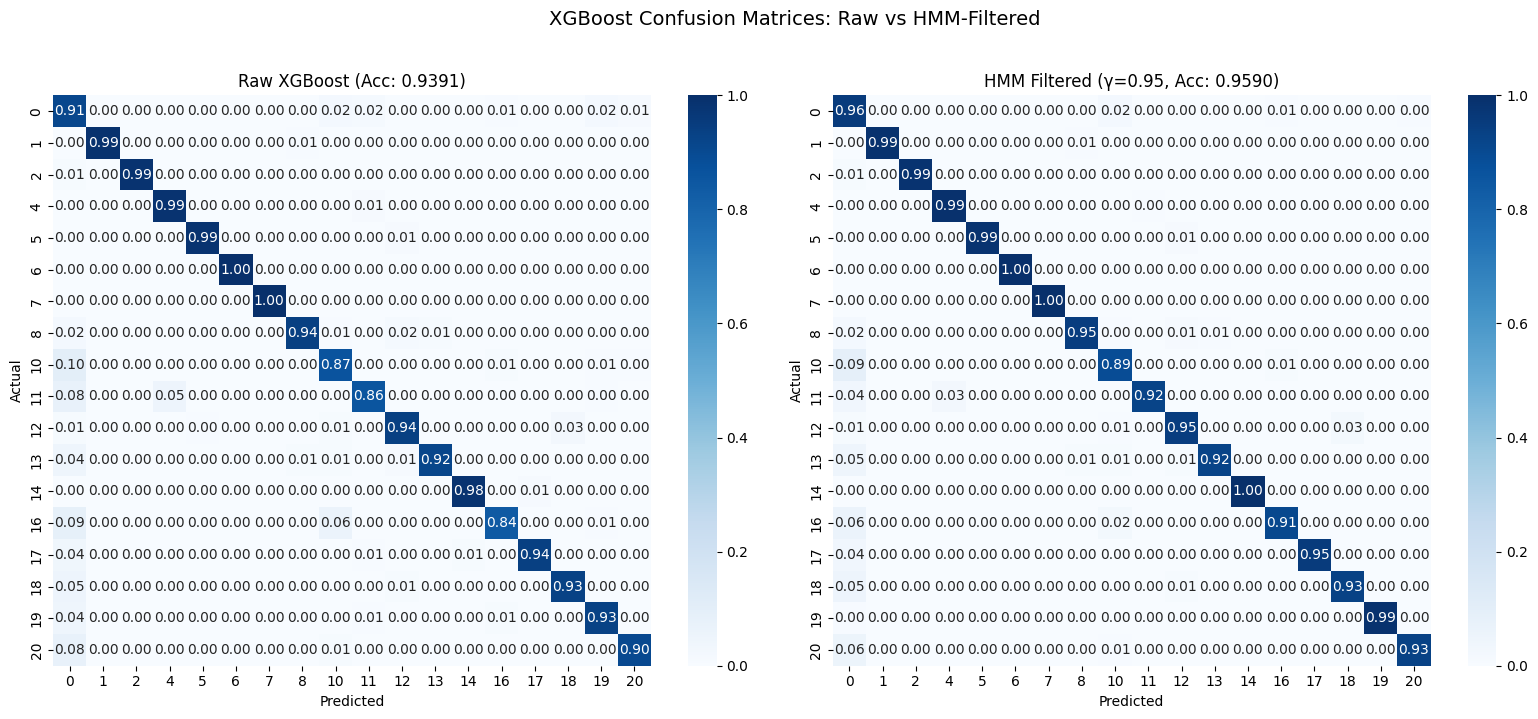

✓ Saved to ../outputs/figures/xgboost_hmm_confusion_matrices.png


In [11]:
# Confusion matrices: Raw vs Best HMM
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

best_stickiness = 0.95

# Raw confusion matrix
cm_raw_norm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_raw_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0],
            vmin=0, vmax=1)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Raw XGBoost (Acc: {raw_metrics["accuracy"]:.4f})')

# HMM filtered confusion matrix
cm_hmm = confusion_matrix(y_test, filtered_predictions[best_stickiness])
cm_hmm_norm = cm_hmm.astype('float') / cm_hmm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_hmm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1],
            vmin=0, vmax=1)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'HMM Filtered (γ={best_stickiness}, Acc: {filtered_metrics[best_stickiness]["accuracy"]:.4f})')

plt.suptitle('XGBoost Confusion Matrices: Raw vs HMM-Filtered', fontsize=14, y=1.02)
plt.tight_layout()
output_file = FIGURES_DIR / 'xgboost_hmm_confusion_matrices.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

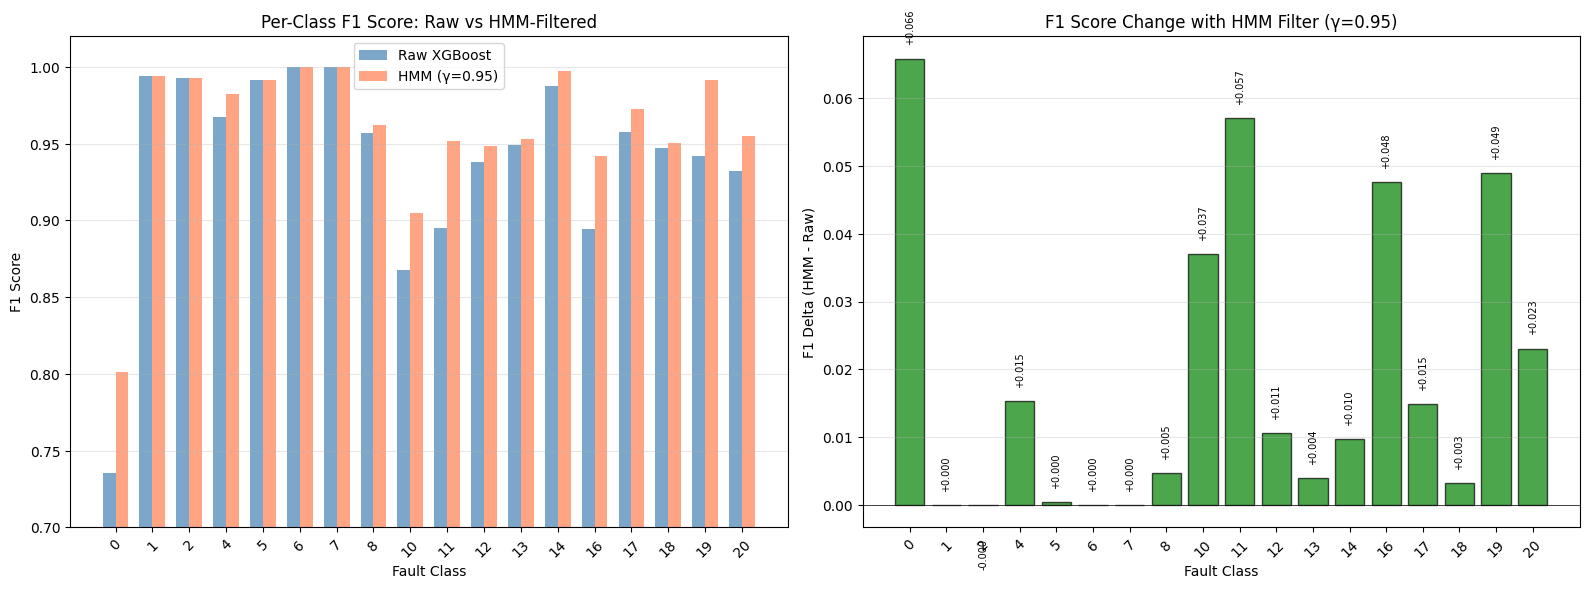

✓ Saved to ../outputs/figures/xgboost_hmm_per_class_f1.png


In [12]:
# Per-class F1 comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
x = np.arange(len(class_names))
width = 0.35

raw_f1s = [raw_metrics['per_class_f1'][c] for c in class_names]
hmm_f1s = [filtered_metrics[best_stickiness]['per_class_f1'][c] for c in class_names]

ax = axes[0]
bars1 = ax.bar(x - width/2, raw_f1s, width, label='Raw XGBoost', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, hmm_f1s, width, label=f'HMM (γ={best_stickiness})', color='coral', alpha=0.7)

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Score: Raw vs HMM-Filtered')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim(0.7, 1.02)
ax.grid(axis='y', alpha=0.3)

# Delta plot
ax = axes[1]
deltas = np.array(hmm_f1s) - np.array(raw_f1s)
colors = ['green' if d >= 0 else 'red' for d in deltas]
bars = ax.bar(class_names, deltas, color=colors, edgecolor='black', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Delta (HMM - Raw)')
ax.set_title(f'F1 Score Change with HMM Filter (γ={best_stickiness})')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, delta in zip(bars, deltas):
    ypos = bar.get_height() + 0.002 if delta >= 0 else bar.get_height() - 0.005
    ax.text(bar.get_x() + bar.get_width()/2, ypos, f'{delta:+.3f}', 
            ha='center', va='bottom' if delta >= 0 else 'top', fontsize=7, rotation=90)

plt.tight_layout()
output_file = FIGURES_DIR / 'xgboost_hmm_per_class_f1.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

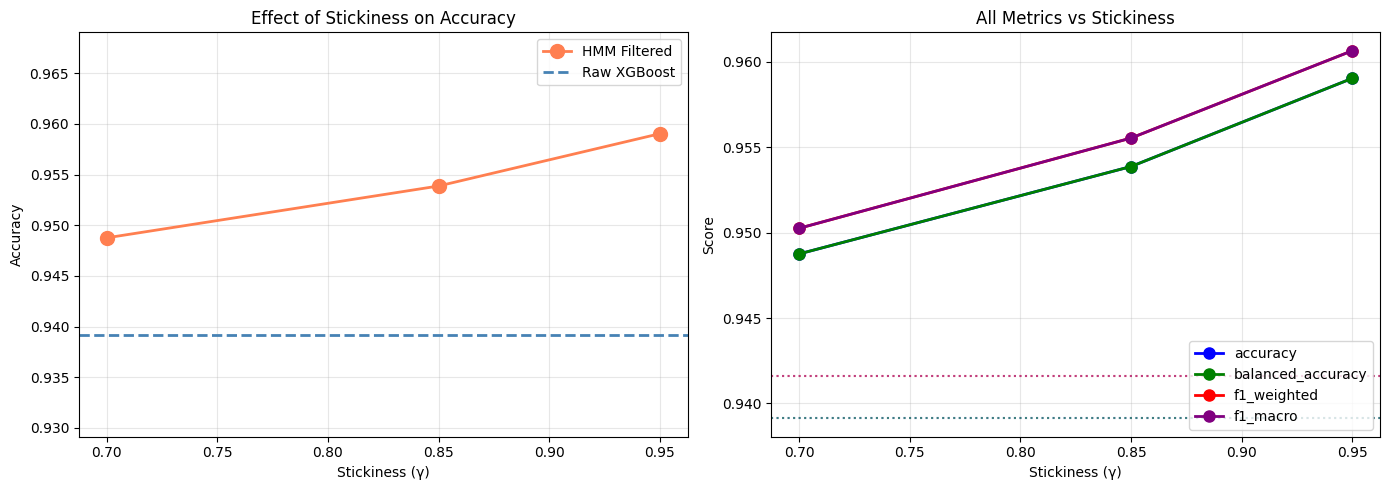

✓ Saved to ../outputs/figures/xgboost_hmm_stickiness_effect.png


In [13]:
# Stickiness effect visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Stickiness
ax = axes[0]
accs = [filtered_metrics[s]['accuracy'] for s in STICKINESS_VALUES]
ax.plot(STICKINESS_VALUES, accs, 'o-', color='coral', linewidth=2, markersize=10, label='HMM Filtered')
ax.axhline(y=raw_metrics['accuracy'], color='steelblue', linestyle='--', linewidth=2, label='Raw XGBoost')
ax.set_xlabel('Stickiness (γ)')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Stickiness on Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(raw_metrics['accuracy'] - 0.01, max(accs) + 0.01)

# Multiple metrics vs Stickiness
ax = axes[1]
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'f1_macro']
colors = ['blue', 'green', 'red', 'purple']

for metric, color in zip(metrics_to_plot, colors):
    values = [filtered_metrics[s][metric] for s in STICKINESS_VALUES]
    ax.plot(STICKINESS_VALUES, values, 'o-', color=color, linewidth=2, markersize=8, label=metric)
    ax.axhline(y=raw_metrics[metric], color=color, linestyle=':', alpha=0.5)

ax.set_xlabel('Stickiness (γ)')
ax.set_ylabel('Score')
ax.set_title('All Metrics vs Stickiness')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / 'xgboost_hmm_stickiness_effect.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

## Save Results

In [14]:
print("\n[Step 6/6] Saving results...")

# Find best stickiness
best_stickiness = max(STICKINESS_VALUES, key=lambda s: filtered_metrics[s]['accuracy'])
best_metrics = filtered_metrics[best_stickiness]

# Compile results
results = {
    'model': 'XGBoost',
    'method': 'HMM Classification Filter',
    'test_samples': len(y_test),
    'n_classes': n_classes,
    'raw_metrics': raw_metrics,
    'filtered_metrics': {str(k): v for k, v in filtered_metrics.items()},
    'best_stickiness': best_stickiness,
    'best_improvement': {
        'accuracy_delta': best_metrics['accuracy'] - raw_metrics['accuracy'],
        'f1_weighted_delta': best_metrics['f1_weighted'] - raw_metrics['f1_weighted'],
        'error_reduction_pct': ((1 - raw_metrics['accuracy']) - (1 - best_metrics['accuracy'])) / (1 - raw_metrics['accuracy']) * 100
    },
    'stickiness_values_tested': STICKINESS_VALUES
}

# Save JSON
output_file = METRICS_DIR / 'xgboost_hmm_filter_results.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Saved metrics to {output_file}")

# Save confusion matrices
cm_raw_df = pd.DataFrame(cm_raw, index=class_names, columns=class_names)
cm_raw_df.to_csv(METRICS_DIR / 'xgboost_hmm_confusion_raw.csv')

cm_hmm_df = pd.DataFrame(cm_hmm, index=class_names, columns=class_names)
cm_hmm_df.to_csv(METRICS_DIR / 'xgboost_hmm_confusion_filtered.csv')
print(f"✓ Saved confusion matrices to {METRICS_DIR}")


[Step 6/6] Saving results...
✓ Saved metrics to ../outputs/metrics/xgboost_hmm_filter_results.json
✓ Saved confusion matrices to ../outputs/metrics


## Summary Report

In [15]:
print("\n" + "="*80)
print("XGBOOST HMM CLASSIFICATION FILTER - SUMMARY REPORT")
print("="*80)

print(f"\n### Dataset")
print(f"Test samples: {len(y_test):,}")
print(f"Number of classes: {n_classes}")
print(f"Number of simulation runs: {test_data.groupby(['faultNumber', 'simulationRun']).ngroups}")

print(f"\n### Raw XGBoost Performance")
print(f"Accuracy: {raw_metrics['accuracy']:.4f}")
print(f"Balanced Accuracy: {raw_metrics['balanced_accuracy']:.4f}")
print(f"F1 (weighted): {raw_metrics['f1_weighted']:.4f}")

print(f"\n### Best HMM Filter (γ={best_stickiness})")
print(f"Accuracy: {best_metrics['accuracy']:.4f} ({results['best_improvement']['accuracy_delta']:+.4f})")
print(f"Balanced Accuracy: {best_metrics['balanced_accuracy']:.4f}")
print(f"F1 (weighted): {best_metrics['f1_weighted']:.4f} ({results['best_improvement']['f1_weighted_delta']:+.4f})")
print(f"Error Reduction: {results['best_improvement']['error_reduction_pct']:.1f}%")

print(f"\n### Per-Class Analysis")
improved = sum(1 for c in class_names if filtered_metrics[best_stickiness]['per_class_f1'][c] > raw_metrics['per_class_f1'][c] + 0.001)
degraded = sum(1 for c in class_names if filtered_metrics[best_stickiness]['per_class_f1'][c] < raw_metrics['per_class_f1'][c] - 0.001)
unchanged = n_classes - improved - degraded
print(f"Classes improved: {improved}/{n_classes}")
print(f"Classes degraded: {degraded}/{n_classes}")
print(f"Classes unchanged: {unchanged}/{n_classes}")

print(f"\n### Conclusion")
if results['best_improvement']['accuracy_delta'] > 0.001:
    print(f"The HMM filter IMPROVES XGBoost classification performance.")
    print(f"Best stickiness: γ={best_stickiness}")
    print(f"Accuracy improvement: {results['best_improvement']['accuracy_delta']:+.4f} ({results['best_improvement']['error_reduction_pct']:.1f}% error reduction)")
elif results['best_improvement']['accuracy_delta'] < -0.001:
    print(f"The HMM filter DEGRADES XGBoost classification performance.")
    print(f"Not recommended for this model.")
else:
    print(f"The HMM filter has MINIMAL effect on XGBoost classification performance.")
    print(f"May not be necessary for this already high-accuracy model.")

print("\n" + "="*80)
print("Outputs:")
print(f"  - {METRICS_DIR / 'xgboost_hmm_filter_results.json'}")
print(f"  - {FIGURES_DIR / 'xgboost_hmm_confusion_matrices.png'}")
print(f"  - {FIGURES_DIR / 'xgboost_hmm_per_class_f1.png'}")
print(f"  - {FIGURES_DIR / 'xgboost_hmm_stickiness_effect.png'}")
print("="*80)


XGBOOST HMM CLASSIFICATION FILTER - SUMMARY REPORT

### Dataset
Test samples: 2,880,000
Number of classes: 18
Number of simulation runs: 3600

### Raw XGBoost Performance
Accuracy: 0.9391
Balanced Accuracy: 0.9391
F1 (weighted): 0.9416

### Best HMM Filter (γ=0.95)
Accuracy: 0.9590 (+0.0199)
Balanced Accuracy: 0.9590
F1 (weighted): 0.9606 (+0.0190)
Error Reduction: 32.7%

### Per-Class Analysis
Classes improved: 13/18
Classes degraded: 0/18
Classes unchanged: 5/18

### Conclusion
The HMM filter IMPROVES XGBoost classification performance.
Best stickiness: γ=0.95
Accuracy improvement: +0.0199 (32.7% error reduction)

Outputs:
  - ../outputs/metrics/xgboost_hmm_filter_results.json
  - ../outputs/figures/xgboost_hmm_confusion_matrices.png
  - ../outputs/figures/xgboost_hmm_per_class_f1.png
  - ../outputs/figures/xgboost_hmm_stickiness_effect.png
